In [77]:
import os
import re

import shutil
import codecs, json 
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from scipy import stats
import sklearn as sk
import time
from dypac import Dypac
import nilearn
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr
import nilearn.plotting as plotting
import feature_selec_functions
import csv

import hcp_utils as hcp

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle

# Load results for plotting

In [90]:
#Paths to tasks
#path to Flanker Task results
path_F = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/df_F.csv'
df_F = pd.read_csv(path_F)

#path to Delay Discount results
path_DD = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/df_DD.csv'
df_DD = pd.read_csv(path_DD)

#path to mars contrast results
path_MC = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/df_MC.csv'
df_MC = pd.read_csv(path_MC)

#path to card sort results
path_CS = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/df_CS.csv'
df_CS = pd.read_csv(path_CS)


## Plot results on brains

In [124]:
#path to df_coords
path_coords = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/df_coords.csv'
df_coords = pd.read_csv(path_coords)
df_coords

,Unnamed: 0,MNI_X,MNI_Y,MNI_Z
0,0,120,18,131
1,1,120,18,132
2,2,120,18,133
3,3,120,18,135
4,4,120,18,136
...,...,...,...,...
95,95,208,62,79
96,96,208,62,80
97,97,208,62,81
98,98,208,62,78


In [125]:
from nilearn.plotting import plot_connectome

plot_connectome(adjacency_matrix=edge_frac_square, edge_threshold=thresh,
                    node_color = color,
                    node_coords=shen268_coords, node_size=node_size,
                    display_mode= 'lzry',
                    edge_kwargs={"linewidth": 1, 'color': color})

In [ ]:
def plot_consistent_edges(all_masks, tail, thresh = 1., color='gray'):
    
    edge_frac = (all_masks[tail].sum(axis=0))/(all_masks[tail].shape[0])
    print("For the {} tail, {} edges were selected in at least {}% of folds".format(tail, (edge_frac>=thresh).sum(), thresh*100))
    edge_frac_square = sp.spatial.distance.squareform(edge_frac)

    node_mask = np.amax(edge_frac_square, axis=0) >= thresh # find nodes that have at least one edge that passes the threshold
    node_size = edge_frac_square.sum(axis=0)*node_mask*20 # size nodes based on how many suprathreshold edges they have

    plot_connectome(adjacency_matrix=edge_frac_square, edge_threshold=thresh,
                    node_color = color,
                    node_coords=shen268_coords, node_size=node_size,
                    display_mode= 'lzry',
                    edge_kwargs={"linewidth": 1, 'color': color})

## Equalize numer of parcels presented in the plot

In [122]:
#path to nodes_map 
path_nodes = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/nodes_map.csv'

#path to parcellation labels 
path_label = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/Parcellations/Parcellations/HCP/fslr32k/cifti/Schaefer2018_100Parcels_7Networks_order_info.txt'

with open(path_label, 'r') as f:
    lines = f.readlines()
    
#lines

In [111]:
#list of parcels
list_parcel = []
for i in range(0, len(lines), 2): #only even rows
    list_parcel.append(lines[i][10:-1])
#len(list_parcel)
list_parcel

['LH_Vis_1',
 'LH_Vis_2',
 'LH_Vis_3',
 'LH_Vis_4',
 'LH_Vis_5',
 'LH_Vis_6',
 'LH_Vis_7',
 'LH_Vis_8',
 'LH_Vis_9',
 'LH_SomMot_1',
 'LH_SomMot_2',
 'LH_SomMot_3',
 'LH_SomMot_4',
 'LH_SomMot_5',
 'LH_SomMot_6',
 'LH_DorsAttn_Post_1',
 'LH_DorsAttn_Post_2',
 'LH_DorsAttn_Post_3',
 'LH_DorsAttn_Post_4',
 'LH_DorsAttn_Post_5',
 'LH_DorsAttn_Post_6',
 'LH_DorsAttn_PrCv_1',
 'LH_DorsAttn_FEF_1',
 'LH_SalVentAttn_ParOper_1',
 'LH_SalVentAttn_FrOperIns_1',
 'LH_SalVentAttn_FrOperIns_2',
 'LH_SalVentAttn_PFCl_1',
 'LH_SalVentAttn_Med_1',
 'LH_SalVentAttn_Med_2',
 'LH_SalVentAttn_Med_3',
 'LH_Limbic_OFC_1',
 'LH_Limbic_TempPole_1',
 'LH_Limbic_TempPole_2',
 'LH_Cont_Par_1',
 'LH_Cont_PFCl_1',
 'LH_Cont_pCun_1',
 'LH_Cont_Cing_1',
 'LH_Default_Temp_1',
 'LH_Default_Temp_2',
 'LH_Default_Par_1',
 'LH_Default_Par_2',
 'LH_Default_PFC_1',
 'LH_Default_PFC_2',
 'LH_Default_PFC_3',
 'LH_Default_PFC_4',
 'LH_Default_PFC_5',
 'LH_Default_PFC_6',
 'LH_Default_PFC_7',
 'LH_Default_pCunPCC_1',
 'LH_Defa

In [170]:
from csv import reader
# read csv file as a list of lists
with open(path_nodes, 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    nodes_map = reader(read_obj)
    # Pass reader object to list() to get a list of lists
    nodes_map = list(nodes_map)
    print(nodes_map)

[['0', '1'], ['0', '2'], ['0', '3'], ['0', '4'], ['0', '5'], ['0', '6'], ['0', '7'], ['0', '8'], ['0', '9'], ['0', '10'], ['0', '11'], ['0', '12'], ['0', '13'], ['0', '14'], ['0', '15'], ['0', '16'], ['0', '17'], ['0', '18'], ['0', '19'], ['0', '20'], ['0', '21'], ['0', '22'], ['0', '23'], ['0', '24'], ['0', '25'], ['0', '26'], ['0', '27'], ['0', '28'], ['0', '29'], ['0', '30'], ['0', '31'], ['0', '32'], ['0', '33'], ['0', '34'], ['0', '35'], ['0', '36'], ['0', '37'], ['0', '38'], ['0', '39'], ['0', '40'], ['0', '41'], ['0', '42'], ['0', '43'], ['0', '44'], ['0', '45'], ['0', '46'], ['0', '47'], ['0', '48'], ['0', '49'], ['0', '50'], ['0', '51'], ['0', '52'], ['0', '53'], ['0', '54'], ['0', '55'], ['0', '56'], ['0', '57'], ['0', '58'], ['0', '59'], ['0', '60'], ['0', '61'], ['0', '62'], ['0', '63'], ['0', '64'], ['0', '65'], ['0', '66'], ['0', '67'], ['0', '68'], ['0', '69'], ['0', '70'], ['0', '71'], ['0', '72'], ['0', '73'], ['0', '74'], ['0', '75'], ['0', '76'], ['0', '77'], ['0', '

In [171]:
range(len(nodes_map))

range(0, 4950)

In [177]:
int(nodes_map[0][0])

0

In [178]:
#create a list of dictionaries which identifies each relevant pair of nodes 
res = []
for i in range(len(nodes_map)):
    dict_res = {}
    lis = nodes_map[i]
    parcel_index = int(lis[0]) #tupples and list_parcels are listed from zero
    dict_res["node1"] = list_parcel[parcel_index]
    parcel_index = int(lis[1])
    dict_res["node2"] = list_parcel[parcel_index]
    res.append(dict_res)
res

[{'node1': 'LH_Vis_1', 'node2': 'LH_Vis_2'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_Vis_3'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_Vis_4'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_Vis_5'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_Vis_6'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_Vis_7'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_Vis_8'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_Vis_9'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_SomMot_1'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_SomMot_2'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_SomMot_3'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_SomMot_4'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_SomMot_5'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_SomMot_6'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_DorsAttn_Post_1'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_DorsAttn_Post_2'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_DorsAttn_Post_3'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_DorsAttn_Post_4'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_DorsAttn_Post_5'},
 {'node1': 'LH_Vis_1', 'node2': 'LH_DorsAttn_Post_6'},
 {'node1': 'LH_Vis_1',

In [179]:
df_nodes = pd.DataFrame(res)
df_nodes

,node1,node2
0,LH_Vis_1,LH_Vis_2
1,LH_Vis_1,LH_Vis_3
2,LH_Vis_1,LH_Vis_4
3,LH_Vis_1,LH_Vis_5
4,LH_Vis_1,LH_Vis_6
...,...,...
4945,RH_Default_PFCdPFCm_2,RH_Default_pCunPCC_1
4946,RH_Default_PFCdPFCm_2,RH_Default_pCunPCC_2
4947,RH_Default_PFCdPFCm_3,RH_Default_pCunPCC_1
4948,RH_Default_PFCdPFCm_3,RH_Default_pCunPCC_2


## Plot results as a circular graph

In [112]:
df = df_F
node_names = list(df.node1) + list(df.node2)
node_names = list(set(node_names))
con = df.beta


In [113]:
df

,Unnamed: 0,node1,node2,beta
0,0,LH_Vis_2,LH_Vis_4,-0.182916
1,1,LH_Vis_2,LH_Vis_5,-0.398821
2,2,LH_Vis_2,RH_SalVentAttn_Med_1,0.101689
3,3,LH_Vis_4,LH_SalVentAttn_PFCl_1,0.096027
4,4,LH_Vis_4,LH_Default_PFC_2,-0.146710
...,...,...,...,...
118,118,RH_Default_Par_1,RH_Default_PFCdPFCm_2,0.132294
119,119,RH_Default_Temp_1,RH_Default_pCunPCC_1,-0.397474
120,120,RH_Default_Temp_2,RH_Default_PFCdPFCm_2,-0.197365
121,121,RH_Default_Temp_3,RH_Default_PFCv_1,0.310444


In [85]:
len(df)
df = df.sort_values(by=['beta'], ascending=False)

df

,Unnamed: 0,node1,node2,beta
9,9,LH_Vis_3,RH_Default_pCunPCC_1,0.698390
104,104,RH_Vis_2,RH_SomMot_4,0.525803
47,47,LH_Limbic_TempPole_2,LH_Default_Par_2,0.524033
41,41,LH_SalVentAttn_FrOperIns_1,LH_Default_PFC_5,0.511130
42,42,LH_SalVentAttn_FrOperIns_1,LH_Default_pCunPCC_1,0.401579
...,...,...,...,...
17,17,LH_Vis_7,RH_SalVentAttn_TempOccPar_1,-0.209285
70,70,LH_Default_PFC_3,RH_DorsAttn_Post_5,-0.211440
112,112,RH_SomMot_1,RH_SomMot_4,-0.291361
82,82,LH_Default_PFC_6,RH_Vis_4,-0.302925


In [20]:
name = 'RH_Default_Temp_2'
net = name.split('_')[1]
net

'Default'

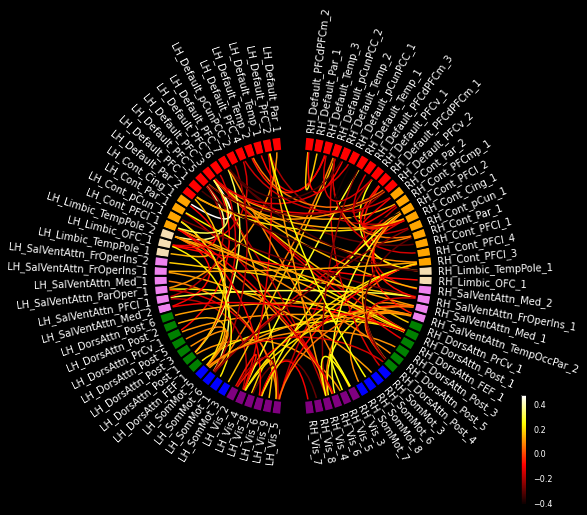

(<Figure size 720x720 with 2 Axes>, <PolarAxesSubplot:>)

In [114]:
i_1 = []
i_2 = []
for f in range(len(df)):
    feature = df.iloc[f,:]
    i_1.append(node_names.index(feature['node1']))
    i_2.append(node_names.index(feature['node2']))
indices = (np.array(i_1), np.array(i_2))

lh_names = [name for name in node_names if 'LH' in name]
rh_names = [name for name in node_names if 'RH' in name]
lh_ordered = []
rh_ordered = []
net_names = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
for network in net_names: 
    lh_net_names = [name for name in lh_names if network in name]
    lh_ordered = lh_ordered + lh_net_names

    rh_net_names = [name for name in rh_names if network in name]
    rh_ordered = rh_ordered + rh_net_names
lh_ordered.reverse()
ordered = lh_ordered + rh_ordered

layout = circular_layout(node_names=node_names, node_order=ordered, group_boundaries=[0, len(lh_ordered)])
colors_list = ['purple', 'blue', 'green', 'violet', 'wheat', 'orange', 'red']
#colors_list = [(120/255, 18/255, 133/255), (70/255, 130/255, 180/255), (0/255, 118/255, 14/255), (196/255, 57/255, 248/255), (220/255, 248/255, 162/255), (230/255, 146/255, 32/255), (204/255, 60/255, 78/255)]

color_dict = dict(zip(net_names, colors_list))
node_colors = []
for name in node_names:
    net = name.split('_')[1]
    node_colors.append(color_dict[net])
    

fig = plt.figure(figsize=[10,10], facecolor='black')
plot_connectivity_circle(con, node_names, indices ,fontsize_names=10, n_lines=200,
                         textcolor='white', facecolor='black', node_angles=layout, 
                        node_colors=node_colors, fig=fig, colorbar=True)

## Plot several graphs together

In [130]:
import plot_con_helper
import importlib

importlib.reload(plot_con_helper)


#Plot results of all 3 tasks
dfs = ['df_DD', 'df_F', 'df_MC']

node_names_lis = []
con_lis = []
indices_lis = []
ordered_lis = []
node_colors_lis = []
layout_lis = []

for i in range(len(dfs)):
    path = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/{}.csv'.format(dfs[i])
    df = pd.read_csv(path)
    node_names, con, indices, ordered, node_colors, layout = plot_con_helper.plot_con_helper(df)
    node_names_lis.append(node_names)
    con_lis.append(con)
    indices_lis.append(indices)
    ordered_lis.append(ordered)
    node_colors_lis.append(node_colors)
    layout_lis.append(layout)
    

In [100]:
layout_lis[1]

array([222.5       , 277.02380952, 402.5       , 262.97619048,
       194.16666667, 238.69047619, 317.5       , 341.78571429,
       357.97619048, 345.83333333, 366.07142857, 281.07142857,
       349.88095238, 141.54761905, 370.11904762, 137.5       ,
       374.16666667, 190.11904762, 378.21428571, 169.88095238,
       165.83333333, 186.07142857, 258.92857143, 157.73809524,
       218.45238095, 353.92857143, 406.54761905, 214.4047619 ,
       410.5952381 , 321.54761905, 414.64285714, 325.5952381 ,
       301.30952381, 234.64285714, 329.64285714, 254.88095238,
       182.02380952, 285.11904762, 418.69047619, 422.73809524,
       426.78571429, 177.97619048, 382.26190476, 250.83333333,
       230.5952381 , 430.83333333, 210.35714286, 333.69047619,
       246.78571429, 133.45238095, 434.88095238, 129.4047619 ,
       386.30952381, 206.30952381, 337.73809524, 438.92857143,
       153.69047619, 390.35714286, 289.16666667, 149.64285714,
       125.35714286, 305.35714286, 362.02380952, 202.26

In [72]:
dfs = ['df_DD', 'df_F', 'df_MC']
df = dfs[0]
df

'df_DD'

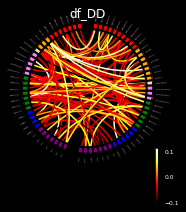

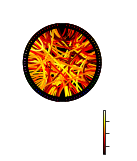

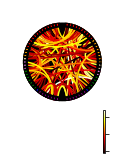

In [145]:
#Plot results of all 3 tasks

fig = plt.figure(num=None, figsize=(10, 5), facecolor='black')
#no_names = [''] * len(label_names)
for ii, df in enumerate(dfs):
    plot_connectivity_circle(con_lis[ii], node_names_lis[ii], indices_lis[ii] ,fontsize_names=0, n_lines=200,
                              textcolor='white', facecolor='black', node_angles=layout_lis[ii], 
                             node_colors=node_colors_lis[ii],
                             title=df, padding=0, fontsize_colorbar=6,
                             fig=fig, subplot=(1, 3, ii + 1))
     
plt.show()

# Find common edges between tasks

In [116]:
import plot_con_helper
import importlib

importlib.reload(plot_con_helper)

dfs = ['df_DD', 'df_F']
df_arranged = {}
for i in range(len(dfs)):
    path = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/{}.csv'.format(dfs[i])
    df = pd.read_csv(path)
    df_arranged[i] = plot_con_helper.arrange_df(df)



In [92]:
range(df_arranged[0].shape[0])


range(0, 50)

In [93]:
df_arranged[0].loc[0]['node1'].split('_')[1]

'DorsAttn'

In [105]:
df_arranged[0]

,Unnamed: 0,node1,node2,beta,beta_abs,node1_nets,node2_nets
0,34,LH_DorsAttn_Post_1,LH_Default_Par_2,0.468552,0.468552,DorsAttn,Default
1,60,LH_Cont_PFCl_1,LH_Default_PFC_3,-0.414531,0.414531,Cont,Default
2,1,LH_Vis_2,LH_Vis_5,-0.398821,0.398821,Vis,Vis
3,119,RH_Default_Temp_1,RH_Default_pCunPCC_1,-0.397474,0.397474,Default,Default
4,45,LH_SalVentAttn_FrOperIns_1,RH_Cont_PFCl_3,0.364223,0.364223,SalVentAttn,Cont
5,11,LH_Vis_5,RH_SalVentAttn_Med_1,0.330371,0.330371,Vis,SalVentAttn
6,103,RH_DorsAttn_Post_4,RH_Cont_Par_1,-0.329442,0.329442,DorsAttn,Cont
7,102,RH_DorsAttn_Post_4,RH_SalVentAttn_FrOperIns_1,-0.325972,0.325972,DorsAttn,SalVentAttn
8,84,LH_Default_PFC_4,RH_Cont_Par_2,-0.314670,0.314670,Default,Cont
9,121,RH_Default_Temp_3,RH_Default_PFCv_1,0.310444,0.310444,Default,Default


In [44]:
type(df_arranged[0])

pandas.core.frame.DataFrame

In [55]:
df_arranged[1]['node2'].split('_')[1] 

AttributeError: 'Series' object has no attribute 'split'

In [117]:
#Compare specific networks
res = []
for i in range(df_arranged[0].shape[0]):
    #print(i)
    node1_val = df_arranged[0].loc[i]['node1']
    node2_val = df_arranged[0].loc[i]['node2']
    #print(node1_val)
    res_tmp = df_arranged[1][(df_arranged[1]['node1'] == node1_val) & (df_arranged[1]['node2'] == node2_val)]
    if res_tmp.shape[0] == 0:
        res_tmp = df_arranged[1][(df_arranged[1]['node2'] == node1_val) & (df_arranged[1]['node1'] == node2_val)]
    if res_tmp.shape[0] == 0:
        continue
    res.append([node1_val, node2_val])

In [118]:
res

[['LH_Vis_4', 'RH_Cont_PFCl_3']]

In [119]:
#Compare only 7 networks
res = []
for i in range(df_arranged[0].shape[0]):
    #print(i)
    node1_org = df_arranged[0].loc[i]['node1']
    node1_val = node1_org.split('_')[1]
    node2_org = df_arranged[0].loc[i]['node2']
    node2_val = node2_org.split('_')[1]
    #print(node1_val)
    res_tmp = df_arranged[1][(df_arranged[1]['node1_nets'] == node1_val) & (df_arranged[1]['node2_nets'] == node2_val)]
    if res_tmp.shape[0] == 0:
        res_tmp = df_arranged[1][(df_arranged[1]['node2_nets'] == node1_val) & (df_arranged[1]['node1_nets'] == node2_val)]
    if res_tmp.shape[0] == 0:
        continue
    res.append([node1_org, node2_org])

In [98]:
union = pd.concat([df_arranged[0], df_arranged[1]])

In [99]:
union

,Unnamed: 0,node1,node2,beta,beta_abs,node1_nets,node2_nets
0,34,LH_DorsAttn_Post_1,LH_Default_Par_2,0.468552,0.468552,DorsAttn,Default
1,60,LH_Cont_PFCl_1,LH_Default_PFC_3,-0.414531,0.414531,Cont,Default
2,1,LH_Vis_2,LH_Vis_5,-0.398821,0.398821,Vis,Vis
3,119,RH_Default_Temp_1,RH_Default_pCunPCC_1,-0.397474,0.397474,Default,Default
4,45,LH_SalVentAttn_FrOperIns_1,RH_Cont_PFCl_3,0.364223,0.364223,SalVentAttn,Cont
...,...,...,...,...,...,...,...
45,71,LH_Default_PFC_3,RH_DorsAttn_PrCv_1,0.120746,0.120746,Default,DorsAttn
46,19,LH_Vis_8,LH_Default_PFC_5,0.120316,0.120316,Vis,Default
47,96,LH_Default_pCunPCC_1,RH_DorsAttn_FEF_1,0.119885,0.119885,Default,DorsAttn
48,50,LH_Default_Temp_1,RH_Vis_4,-0.118318,0.118318,Default,Vis


In [100]:
unique_sum = union.groupby(['node1_nets', 'node2_nets'])
unique_sum

In [101]:
union.groupby(['node1', 'node2']).ngroups

99

In [120]:
len(res)

43

In [121]:
res

[['LH_Cont_Cing_1', 'RH_SalVentAttn_TempOccPar_1'],
 ['LH_Cont_pCun_1', 'RH_SalVentAttn_TempOccPar_1'],
 ['LH_Cont_Cing_1', 'RH_Cont_PFCl_2'],
 ['LH_Vis_4', 'RH_Cont_PFCmp_1'],
 ['RH_Default_Par_1', 'RH_Default_PFCv_1'],
 ['LH_Default_PFC_7', 'RH_Default_PFCdPFCm_2'],
 ['LH_Vis_4', 'LH_Cont_Cing_1'],
 ['RH_SalVentAttn_TempOccPar_1', 'RH_Cont_Cing_1'],
 ['LH_Cont_Cing_1', 'RH_Cont_PFCl_3'],
 ['LH_DorsAttn_PrCv_1', 'RH_SalVentAttn_TempOccPar_2'],
 ['RH_Cont_PFCl_1', 'RH_Cont_PFCl_2'],
 ['LH_Cont_Cing_1', 'RH_Vis_4'],
 ['RH_SalVentAttn_TempOccPar_1', 'RH_Cont_Par_1'],
 ['LH_Vis_4', 'LH_SalVentAttn_PFCl_1'],
 ['LH_Vis_7', 'LH_Cont_pCun_1'],
 ['LH_Cont_pCun_1', 'RH_Cont_PFCl_2'],
 ['LH_DorsAttn_Post_1', 'LH_Cont_pCun_1'],
 ['LH_Vis_4', 'RH_Cont_PFCl_3'],
 ['RH_SalVentAttn_TempOccPar_1', 'RH_Cont_PFCmp_1'],
 ['LH_Cont_Cing_1', 'LH_Default_Par_1'],
 ['RH_SalVentAttn_TempOccPar_1', 'RH_Cont_PFCl_3'],
 ['LH_Cont_pCun_1', 'LH_Default_Par_1'],
 ['LH_Cont_pCun_1', 'RH_SalVentAttn_TempOccPar_2'],
 

In [18]:
node1_nets = []
for val in df_arranged[0]['node1']:
    #print(val)
    net = val.split('_')[1]
    node1_nets.append(net)
node1_nets



['ContC',
 'SalVentAttnA',
 'ContC',
 'ContC',
 'VisCent',
 'DefaultA',
 'DefaultA',
 'VisCent',
 'ContC',
 'ContC',
 'ContA',
 'ContA',
 'ContC',
 'SalVentAttnB',
 'VisCent',
 'DorsAttnA',
 'ContC',
 'DorsAttnA',
 'VisCent',
 'SalVentAttnB',
 'ContC',
 'SalVentAttnB',
 'ContC',
 'ContC',
 'ContA',
 'ContC',
 'SalVentAttnB',
 'DefaultA',
 'SalVentAttnA',
 'ContC',
 'DorsAttnB',
 'DorsAttnB',
 'DefaultB',
 'DorsAttnB',
 'SomMotA',
 'SalVentAttnA',
 'ContC',
 'SalVentAttnB',
 'DorsAttnB',
 'ContC',
 'ContC',
 'ContA',
 'DefaultC',
 'ContC',
 'ContA',
 'DorsAttnB',
 'ContC',
 'DorsAttnB',
 'VisPeri',
 'ContA']

In [67]:
df_arranged[0]['node1_nets'] = node1_nets

In [68]:
df_arranged[0]['node1_nets']

0            Cont
1     SalVentAttn
2            Cont
3            Cont
4             Vis
5         Default
6         Default
7             Vis
8     SalVentAttn
9            Cont
10       DorsAttn
11           Cont
12           Cont
13    SalVentAttn
14            Vis
15            Vis
16           Cont
17       DorsAttn
18            Vis
19    SalVentAttn
20           Cont
21    SalVentAttn
22           Cont
23           Cont
24           Cont
25           Cont
26    SalVentAttn
27        Default
28    SalVentAttn
29           Cont
30       DorsAttn
31       DorsAttn
32        Default
33       DorsAttn
34         SomMot
35    SalVentAttn
36           Cont
37           Cont
38       DorsAttn
39           Cont
40           Cont
41       DorsAttn
42            Vis
43           Cont
44       DorsAttn
45       DorsAttn
46           Cont
47       DorsAttn
48            Vis
49       DorsAttn
Name: node1_nets, dtype: object